# Training Engineering and Model Assessment

In this notebook we demonstrate several training strategies for a classical ML model. In the previous notebook (Auto ML and Hyperparameter Tuning), we learned that the two best classical models for the forest mortality dataset are XGBoost and K nearest neighbors. Our demonstrations here will focus on these two model architectures.

## Setup & Get data

In [1]:
from google.cloud.storage import Client
import pandas as pd
import random

client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="preisler-rectangular")
    if f.name.endswith("csv") and "v2" in f.name
]

random.shuffle(records)

ds_raw = pd.concat((pd.read_csv(f).drop(["system:index", ".geo"], axis=1) for f in records), ignore_index=True)
ds_raw.describe()

,elev,fire,latitude,longitude,mort,near,prcp,rhost,rwc,tmin,year
count,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000
mean,1303.270783,0.023833,38.577064,-120.746418,0.033068,0.096016,890.434095,0.609584,0.481069,-6.847528,2010.156456
std,766.687703,0.152530,2.390281,1.906977,0.111545,0.191194,574.062383,0.403451,0.169081,5.493595,4.982501
min,-8.000000,0.000000,32.567223,-124.237004,0.000000,0.000000,0.000000,0.000000,-0.460538,-38.072500,1999.000000
25%,700.000000,0.000000,36.934637,-122.368508,0.000000,0.000000,445.753747,0.107449,0.361022,-10.785000,2006.000000
50%,1264.000000,0.000000,38.918471,-120.787473,0.000000,0.006400,766.938748,0.808041,0.484713,-5.815000,2010.000000
75%,1767.000000,0.000000,40.657817,-119.242371,0.004000,0.088800,1211.563124,0.973054,0.597517,-2.387500,2014.000000
max,3914.000000,1.000000,42.006813,-115.074188,1.000000,1.000000,4567.319967,1.000000,1.293637,5.891667,2018.000000


In [2]:
# Convert to xarray dataset and shfit coordinates
import xarray as xr

ds_xr = ds_raw.set_index(["latitude", "longitude", "year"])\
    .to_xarray()

# Shift mortality back in time one year so we are predicting *next year's* mortality
ds_xr["mort"] = ds_xr["mort"].shift(year=-1)

ds = ds_xr.to_dataframe().dropna().reset_index()
ds.head()

,latitude,longitude,year,elev,fire,mort,near,prcp,rhost,rwc,tmin
0,32.567223,-116.763021,2009,250.0,0.0,0.0,0.0000,236.505001,0.0,0.356233,2.77625
1,32.597501,-116.763021,2009,401.0,0.0,0.0,0.0000,257.892500,0.0,0.356233,1.90625
2,32.597501,-116.727088,2009,409.0,0.0,0.0,0.0024,256.935000,0.0,0.285585,1.19250
3,32.597501,-116.727088,2010,409.0,0.0,0.0,0.0000,454.710006,0.0,0.387257,2.23250
4,32.597501,-116.727088,2011,409.0,0.0,0.0,0.0000,407.125001,0.0,0.280304,0.90250


In [3]:
print(f"{ds.shape[0]} rows of data")

252500 rows of data


In [4]:
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

from matplotlib import pyplot as plt
import numpy as np

## Data Splitting and Cross Validation

Here we demonstrate splitting data into test/train sets and using cross-validation to evaluate uncertainty in model performance. Note that preprocessing with `StandardScaler` can only happen on the training dataset so that information from the test set does not leak into the training workflow.

In [5]:
# Apply preprocessing. This doesn't really matter for XGB but it does matter for KNN
# so might as well get it done now.
target = "mort"
exclude = ["year"]
bands = [b for b in ds.columns if b != target and b not in exclude]

X = ds[bands].to_numpy()
y = ds[target].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

In [6]:
# Run cross-validation with 10 folds.
my_xgb = xgb.XGBRegressor()
cv_result = cross_validate(my_xgb, X_train_std, y_train, 
                           scoring="neg_root_mean_squared_error", cv=10)

In [7]:
cv_result

{'fit_time': array([0.71657205, 0.69358397, 0.69175124, 0.70505428, 0.70409942,
        0.70350718, 0.70233798, 0.7074213 , 0.70577168, 0.69069648]),
 'score_time': array([0.0206883 , 0.02088618, 0.02077579, 0.02081037, 0.02075052,
        0.02086782, 0.02076292, 0.02098274, 0.01978302, 0.01969838]),
 'test_score': array([-0.08509574, -0.08624472, -0.09097674, -0.08723309, -0.08469996,
        -0.08698746, -0.08609158, -0.08607365, -0.08725527, -0.08606462])}

Note that the above scores are derived from the validation set held out of training during each cross-validation run. How well did cross-validation indicate model performance? We do a final fit to the entire training set and then compare the results from cross-validation with performance on the test set.

In [8]:
my_xgb.fit(X_train_std, y_train)
y_hat = my_xgb.predict(X_test_std)
test_rmse = root_mean_squared_error(y_test, y_hat)

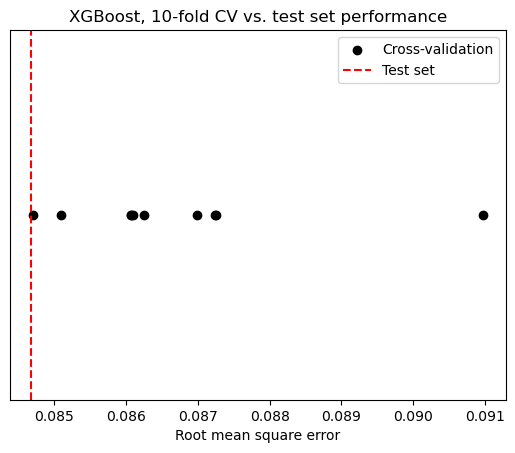

In [9]:
cv_rmse = cv_result["test_score"] * -1

plt.scatter(cv_rmse, np.ones(cv_rmse.shape), color="black", label="Cross-validation")
plt.axvline(x=test_rmse, color="red", linestyle="--", label="Test set")
plt.legend()
plt.gca().get_yaxis().set_visible(False)
plt.xlabel("Root mean square error")
plt.title("XGBoost, 10-fold CV vs. test set performance")
plt.show()

We find that model performance on the test set is consistent with that observed during cross-validation.

## Performance Generality

A common way to test generality in remote sensing is to compare model performance across ecoregions. Ecoregions are categorical classifications of the landscape according to local climate and the dominant plant community. Our input data include a diverse set of ecologies, and in a managment context we want our model to generalize well across these units. Is model performance consistent across all ecoregions in the dataset?

In [10]:
import os
if "notebooks" in os.getcwd():
    os.chdir("..")

In [11]:
!curl https://gaftp.epa.gov/EPADataCommons/ORD/Ecoregions/ca/ca_eco_l3.zip -k -o data_working/ca_ecoregions.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2248k  100 2248k    0     0   101k      0  0:00:22  0:00:22 --:--:--  460k    0    0     0      0      0 --:--:--  0:00:13 --:--:--     0


In [12]:
!unzip -o data_working/ca_ecoregions.zip -d data_working

Archive:  data_working/ca_ecoregions.zip
  inflating: data_working/ca_eco_l3.dbf  
  inflating: data_working/ca_eco_l3.prj  
  inflating: data_working/ca_eco_l3.sbn  
  inflating: data_working/ca_eco_l3.sbx  
  inflating: data_working/ca_eco_l3.shp  
  inflating: data_working/ca_eco_l3.shp.xml  
  inflating: data_working/ca_eco_l3.shx  


In [13]:
# Add ecoregion to input data
import geopandas as gpd

ecoregions = gpd.read_file("data_working/ca_eco_l3.shp").to_crs("EPSG:4326")
px_geom    = gpd.points_from_xy(X_test[:, 1], X_test[:, 0], crs="EPSG:4326")
px_as_pts  = gpd.GeoDataFrame(geometry=px_geom)

ecoregions.head()

,US_L3CODE,US_L3NAME,NA_L3CODE,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,STATE_NAME,EPA_REGION,L3_KEY,L2_KEY,L1_KEY,geometry
0,1,Coast Range,7.1.8,Coast Range,7.1,MARINE WEST COAST FOREST,7,MARINE WEST COAST FOREST,California,10,1 Coast Range,7.1 MARINE WEST COAST FOREST,7 MARINE WEST COAST FOREST,"MULTIPOLYGON (((-122.47152 37.63402, -122.4715..."
1,13,Central Basin and Range,10.1.5,Central Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,California,10,13 Central Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,"MULTIPOLYGON (((-117.24373 37.02862, -117.2491..."
2,14,Mojave Basin and Range,10.2.1,Mojave Basin and Range,10.2,WARM DESERTS,10,NORTH AMERICAN DESERTS,California,9,14 Mojave Basin and Range,10.2 WARM DESERTS,10 NORTH AMERICAN DESERTS,"POLYGON ((-117.83197 37.32737, -117.82846 37.3..."
3,4,Cascades,6.2.7,Cascades,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,10,4 Cascades,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,"POLYGON ((-122.22141 41.94569, -122.21901 41.9..."
4,5,Sierra Nevada,6.2.12,Sierra Nevada,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,9,5 Sierra Nevada,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,"POLYGON ((-120.88387 40.41221, -120.87907 40.4..."


Text(0, 0.5, '')

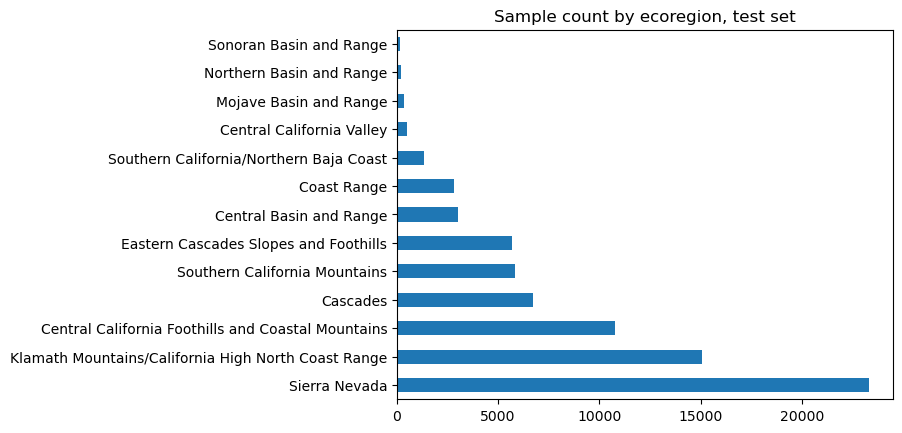

In [14]:
px_ecoreg = gpd.sjoin(px_as_pts, ecoregions[["US_L3NAME", "geometry"]], how="left")
px_ecoreg.US_L3NAME.value_counts().plot(kind="barh")
plt.title("Sample count by ecoregion, test set")
plt.ylabel("")

In [15]:
log_test_residual = np.log10(np.abs(y_test - y_hat))
all_ecoreg = px_ecoreg.US_L3NAME.unique().astype(str)
all_ecoreg = all_ecoreg[~(all_ecoreg == 'nan')]
resid_by_group = [
    log_test_residual[px_ecoreg.US_L3NAME == ecoreg] for ecoreg in all_ecoreg
]

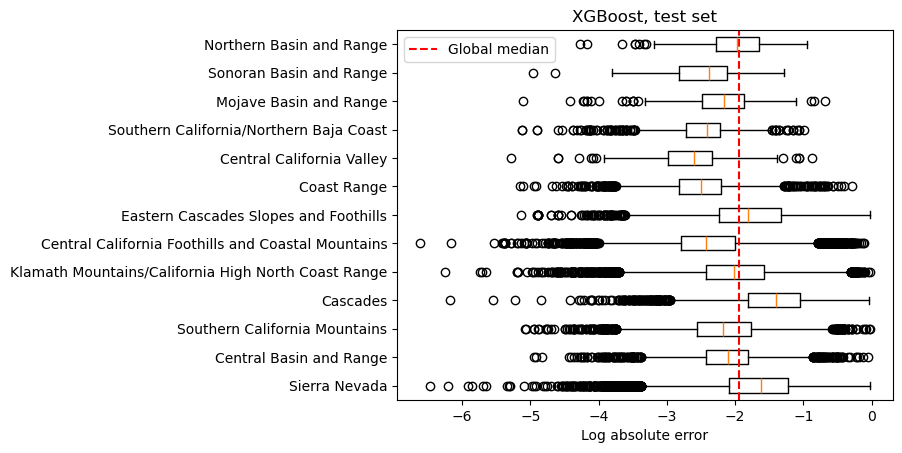

In [16]:
plt.boxplot(resid_by_group, tick_labels=all_ecoreg, vert=False)
plt.title("XGBoost, test set")
plt.xlabel("Log absolute error")
plt.axvline(np.median(log_test_residual), color="red", linestyle="--", label="Global median")
plt.legend()
plt.show()

Error is fairly consistent across ecoregions. The middle 50% of almost all ecoregions overlaps with the global median error on the test set. Some exceptions are the Southern California Coast, Northern Basin, Coast Range, and Central California Valley.

## Bootstrapping and Bagging

Since XGBoost uses a form of bagging to fit each individual estimator, it does not make sense to use this model architecture to demonstrate bagging. Instead, we will use the K nearest neighbor regressor to evaluate this technique. Here we compare performance of K nearest neighbor regression with one estimator fitted to the whole dataset versus an ensemble of estimators fit to bootstrapped subsets of the data.

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

k = 10
n_estimators = 10

knn_base = KNeighborsRegressor(n_neighbors=k)
knn_bag  = BaggingRegressor(n_estimators=n_estimators, max_samples=1/n_estimators)

knn_base.fit(X_train_std, y_train)
knn_bag.fit(X_train_std, y_train)

BaggingRegressor(max_samples=0.1)

Now we evaluate how these models perform on the test set.

In [18]:
y_hat_base = knn_base.predict(X_test_std)
y_hat_bag  = knn_bag.predict(X_test_std)

base_bag_df = pd.DataFrame(data=dict(
    model=["base", "bagged"],
    rmse=[root_mean_squared_error(y_test, y_hat_base), root_mean_squared_error(y_test, y_hat_bag)],
    R2=[knn_base.score(X_test_std, y_test), knn_bag.score(X_test_std, y_test)]
))

base_bag_df

,model,rmse,R2
0,base,0.087317,0.418515
1,bagged,0.095286,0.307544


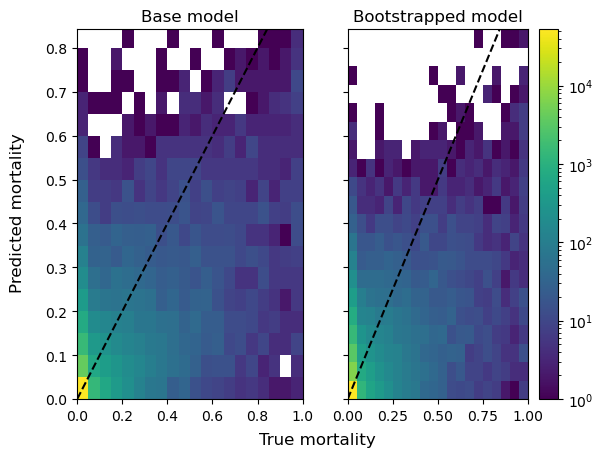

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist2d(y_test, y_hat_base, norm="log", bins=20)
ax1.axline((0, 0), slope=1, color="black", linestyle="--")
ax1.set_title("Base model")

h = ax2.hist2d(y_test, y_hat_bag, norm="log", bins=20)
ax2.axline((0, 0), slope=1, color="black", linestyle="--")
ax2.set_title("Bootstrapped model")

fig.colorbar(h[3])

fig.supxlabel("True mortality")
fig.supylabel("Predicted mortality")

plt.show()

Performance seems slighty worse in the bootstrapped model than in the base model. This result makes sense when we consider that the KNN regressor essentially memorizes the training data to make predictions. Removing a portion of this data, as we did when bootstrapping, would lead to reduced performance.

## Visualizing Performance

Our work above includes many visualizations used to interpret machine learning models. However, one visualization we have not shown is a learning curve. In brief, this visualization shows the relative performance of a model on the training and test sets as more data is added to the training set.

In [20]:
from sklearn.model_selection import learning_curve, LearningCurveDisplay

train_sizes, train_scores, test_scores = learning_curve(my_xgb, X_train_std, y_train, scoring="neg_root_mean_squared_error")

In [21]:
# Convert to positve RMSE
if np.any(train_scores < 0): train_scores *= -1
if np.any(test_scores < 0): test_scores *= -1

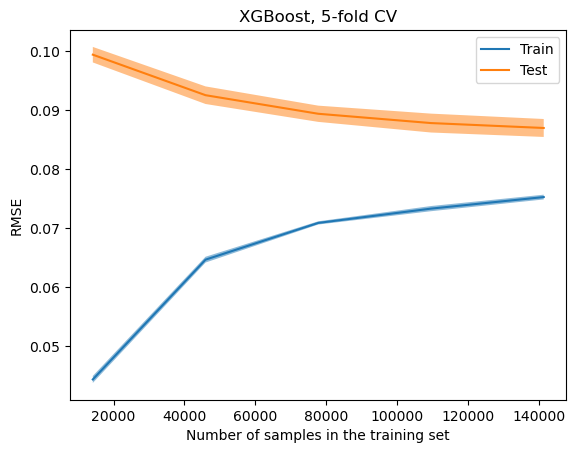

In [22]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="RMSE")
display.plot()
plt.title("XGBoost, 5-fold CV")
plt.show()

As the number of samples in the training set increases, performance on the training set worsens while performance on the test set improves. This trend indicates that the full volume of data we provide is necessary for the model to have the best performance.

## Discussion

In this notebook we demonstrated several training strategies for predicting forest mortality with XGBoost and a K nearest neighbors regressor. As in the AutoML notebook, XGBoost performed better than K nearest neighbors.

### Model generality

We ensured model generality by splitting the data into training and test sets at the beginning of this notebook. During model training, we used cross-validation to understand uncertainty in model performance metrics. When we compared model performance across folds with performance on the test set, we found that the model performed similarly well. Model performance was also comparable across ecoregions in the test set. Taken together, these observations indicate that our training workflow for the XGBoost model produces a model that generalizes well.

Since XGBoost uses bootstrapping as part of its training procedure, we demonstrated bootstrapping on the K nearest neighbors regressor. Here the bagged and unbagged models produced similar performance, with the unbagged model performing slightly better. This result may come from the fact that the performance of a K nearest neighbors regressor is directly related to the amount of data available during training. Therefore, bagging harms model performance moreso than with XGBoost.

### Model performance

Cross-validation had no effect on overall model performance. We found comparable performance metrics between individual folds of cross validation and the final model fitted to the entire training dataset. From our learning curve with the K nearest neighbors regressor, we learned that including the full dataset in training is necessary to achieve the best performance on the test dataset.